# S&P 500 Best and Worst Days Analysis

**Data Source:** [S&P 500 Historical Data - Stooq](https://stooq.com/q/d/?s=%5Espx)

**Note:** Historical data prior to 1957 (when the S&P 500 Index was officially founded) are "rebuilt" using retroactive calculations based on constituent companies that would have been included.

**Disclaimer:** This analysis is for educational purposes only and should not be considered as financial advice.

This notebook performs exploratory data analysis and visualization of S&P 500 historical price data.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-10-10.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,0.0
1789-06-01,0.51,0.51,0.51,0.51,0.0
1789-07-01,0.50,0.50,0.50,0.50,0.0
1789-08-01,0.50,0.51,0.50,0.51,0.0
1789-09-01,0.51,0.51,0.50,0.51,0.0


In [25]:
# filter DatetimeIndex higher than year 1957
df = df[df.index > '1957-01-01']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17311 entries, 1957-01-02 to 2025-10-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    17311 non-null  float64
 1   high    17311 non-null  float64
 2   low     17311 non-null  float64
 3   close   17311 non-null  float64
 4   volume  17311 non-null  float64
dtypes: float64(5)
memory usage: 811.5 KB


In [26]:
df.shape

(17311, 5)

In [27]:
# # plot close prices over time
# plt.figure(figsize=(14, 7))
# plt.plot(df.index, df['close'], label='Close Price')
# plt.title('S&P 500 Close Prices Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid()
# plt.show()

In [28]:
# Calculate simple returns with pct_change()
simple_returns = df['close'].pct_change().fillna(0)

# Calculate log returns
log_returns = (1 + simple_returns).apply(np.log)

# Cumulative sum of simple returns (not correct for compounding)
cumsum_simple = simple_returns.cumsum()

In [29]:
simple_returns.tail()

date
2025-10-06    0.003647
2025-10-07   -0.003811
2025-10-08    0.005828
2025-10-09   -0.002756
2025-10-10   -0.027112
Name: close, dtype: float64

In [30]:
# top 100 worst days
worst_days = simple_returns.nsmallest(100)

# top 100 best days
best_days = simple_returns.nlargest(100)

# print results
print("Top 100 Worst Days:")
print(worst_days)

print("\nTop 100 Best Days:")
print(best_days)

Top 100 Worst Days:
date
1987-10-19   -0.204669
2020-03-16   -0.119841
2020-03-12   -0.095113
2008-10-15   -0.090350
2008-12-01   -0.089295
                ...   
2018-10-10   -0.032864
2022-06-16   -0.032512
2018-12-04   -0.032365
2010-05-06   -0.032354
2002-09-27   -0.032259
Name: close, Length: 100, dtype: float64

Top 100 Best Days:
date
2008-10-13    0.115800
2008-10-28    0.107890
2025-04-09    0.095154
2020-03-24    0.093828
2020-03-13    0.092871
                ...   
2000-10-13    0.033381
2000-04-25    0.033276
2003-01-02    0.033200
2000-04-17    0.033084
2010-05-27    0.032876
Name: close, Length: 100, dtype: float64


In [31]:
# window size from best and worst days
window_size = [5, 10, 30, 60, 90] # days

# Fixed function that calculates the cumulative sum of simple returns, from one of the worst days, for a given window size
def cumulative_return_from_day(day, window):
    try:
        start_idx = simple_returns.index.get_loc(day)
        end_idx = min(start_idx + window, len(simple_returns))  # Prevent index overflow
        
        # Check if we have enough data points
        if end_idx - start_idx < window:
            # If not enough data, pad with the available data
            available_data = simple_returns.iloc[start_idx:end_idx]
            # Create a series with the requested window size, filling missing values with 0
            padded_data = pd.Series(index=range(window), dtype=float)
            padded_data.iloc[:len(available_data)] = available_data.values
            padded_data = padded_data.fillna(0)
            return padded_data.cumsum()
        else:
            return simple_returns.iloc[start_idx:end_idx].cumsum()
    except (KeyError, IndexError):
        # If date doesn't exist, return a series of zeros
        return pd.Series([0] * window).cumsum()

# call the function for each of the worst days and each window size
cumulative_worst = {window: [] for window in window_size}
successful_days = {window: [] for window in window_size}  # Track which days worked

for day in worst_days.index:
    for window in window_size:
        cum_ret = cumulative_return_from_day(day, window)
        if not cum_ret.isna().all():  # Only add if not all NaN
            cumulative_worst[window].append(cum_ret)
            if window == 5:  # Track successful days for the first window only
                successful_days[window].append(day)

# convert lists to DataFrames with proper indexing
for window in window_size:
    if cumulative_worst[window]:  # Only if we have data
        cumulative_worst[window] = pd.DataFrame(cumulative_worst[window]).T
        # Set proper column names (day indices)
        cumulative_worst[window].columns = range(len(cumulative_worst[window].columns))
    else:
        cumulative_worst[window] = pd.DataFrame()  # Empty DataFrame

print(f"Successfully processed {len(cumulative_worst[5].columns)} worst days for 5-day window")
cumulative_worst[5].head()

Successfully processed 100 worst days for 5-day window


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
1961-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Window 5 days: 100 valid recovery periods
Window 10 days: 100 valid recovery periods
Window 30 days: 100 valid recovery periods
Window 60 days: 100 valid recovery periods
Window 90 days: 100 valid recovery periods


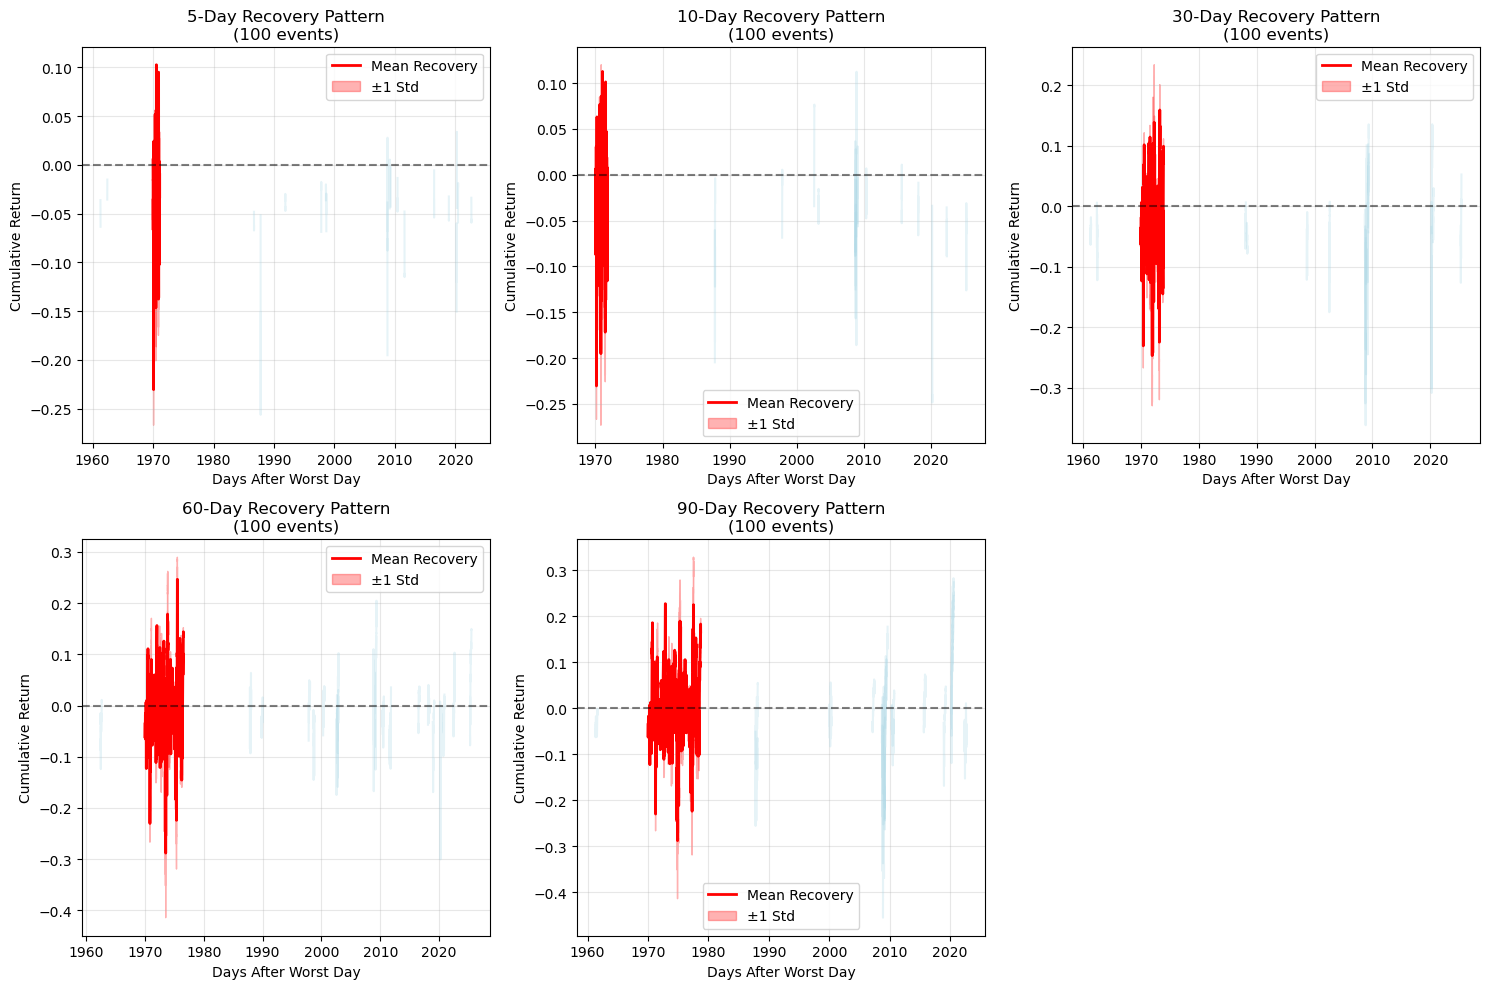


Recovery Summary Statistics:
5-day window:
  Average cumulative return: -3.27%
  Probability of positive return: 0.0%
  Number of events analyzed: 100

10-day window:
  Average cumulative return: 0.71%
  Probability of positive return: 1.0%
  Number of events analyzed: 100

30-day window:
  Average cumulative return: 7.12%
  Probability of positive return: 1.0%
  Number of events analyzed: 100

60-day window:
  Average cumulative return: 13.55%
  Probability of positive return: 1.0%
  Number of events analyzed: 100

90-day window:
  Average cumulative return: 16.54%
  Probability of positive return: 1.0%
  Number of events analyzed: 100



In [32]:
# Enhanced version with better error handling and statistics
def analyze_recovery_patterns():
    """Analyze recovery patterns after worst market days"""
    
    recovery_stats = {}
    
    for window in window_size:
        valid_recoveries = []
        
        for day in worst_days.index:
            try:
                start_idx = simple_returns.index.get_loc(day)
                end_idx = min(start_idx + window, len(simple_returns))
                
                if end_idx - start_idx >= window:  # Only use if we have full window
                    recovery = simple_returns.iloc[start_idx:end_idx].cumsum()
                    valid_recoveries.append(recovery)
            except (KeyError, IndexError):
                continue
        
        if valid_recoveries:
            recovery_df = pd.DataFrame(valid_recoveries).T
            
            # Calculate statistics
            mean_recovery = recovery_df.mean(axis=1)
            median_recovery = recovery_df.median(axis=1)
            std_recovery = recovery_df.std(axis=1)
            
            recovery_stats[window] = {
                'data': recovery_df,
                'mean': mean_recovery,
                'median': median_recovery,
                'std': std_recovery,
                'count': len(valid_recoveries)
            }
            
            print(f"Window {window} days: {len(valid_recoveries)} valid recovery periods")
    
    return recovery_stats

# Run the analysis
recovery_analysis = analyze_recovery_patterns()

# Plot the results
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in recovery_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot individual recovery paths (sample)
        sample_data = recovery_analysis[window]['data'].sample(min(20, recovery_analysis[window]['count']), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightblue')
        
        # Plot mean and confidence bands
        mean_recovery = recovery_analysis[window]['mean']
        std_recovery = recovery_analysis[window]['std']
        
        days = range(len(mean_recovery))
        plt.plot(days, mean_recovery, 'r-', linewidth=2, label='Mean Recovery')
        plt.fill_between(days, 
                        mean_recovery - std_recovery, 
                        mean_recovery + std_recovery, 
                        alpha=0.3, color='red', label='±1 Std')
        
        plt.title(f'{window}-Day Recovery Pattern\n({recovery_analysis[window]["count"]} events)')
        plt.xlabel('Days After Worst Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add horizontal line at zero
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nRecovery Summary Statistics:")
print("=" * 50)
for window in window_size:
    if window in recovery_analysis:
        final_return = recovery_analysis[window]['mean'].iloc[-1]
        prob_positive = (recovery_analysis[window]['data'].iloc[-1] > 0).mean()
        print(f"{window}-day window:")
        print(f"  Average cumulative return: {final_return:.2%}")
        print(f"  Probability of positive return: {prob_positive:.1%}")
        print(f"  Number of events analyzed: {recovery_analysis[window]['count']}")
        print()